# Image Classification with CNNs using Keras

# Task 1: Import Libraries

In [1]:
import tensorflow as tf
import os
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')
    
print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 1.14.0
Is using GPU? False


# Task 2: Preprocess Data

In [2]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train, y_train = get_three_classes(x_train, y_train)
x_test, y_test = get_three_classes(x_test, y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


# Task 3: Visualize Examples

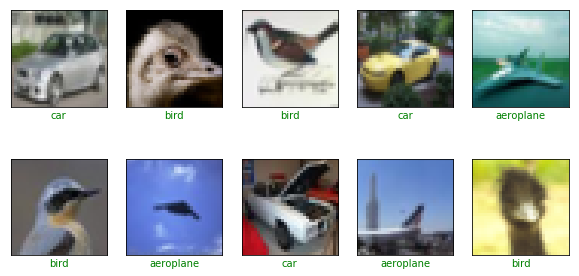

In [4]:
class_names = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_train, y_train, y_train)

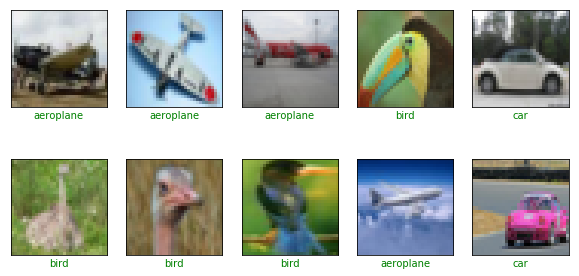

In [5]:
show_random_examples(x_test, y_test, y_test)

# Task 4: Create Model

In [6]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

def create_model():
    
    def add_conv_block(model, num_filters):
        
        model.add(Conv2D(num_filters, 3, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation='relu', padding='valid'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.2))

        return model
    
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(32, 32, 3)))
    
    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)

    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
____

# Task 5: Train the Model

In [7]:
%%time

h = model.fit(
    x_train/255., 
    y_train,
    validation_data=(x_test/255., y_test),
    epochs=20, 
    batch_size=256,
    
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=2),
        tf.keras.callbacks.ModelCheckpoint('models/model_{val_acc:.3f}.h5', 
                                           save_best_only=True,
                                           save_weights_only=False, 
                                           monitor='val_acc')
    ]
)

Train on 15000 samples, validate on 3000 samples
Epoch 1/20
15000/15000 [==============================] - 60s 4ms/sample - loss: 0.7097 - acc: 0.7267 - val_loss: 1.6259 - val_acc: 0.3333
Epoch 2/20
15000/15000 [==============================] - 84s 6ms/sample - loss: 0.4496 - acc: 0.8235 - val_loss: 2.1640 - val_acc: 0.3333
Epoch 3/20
15000/15000 [==============================] - 84s 6ms/sample - loss: 0.3730 - acc: 0.8544 - val_loss: 2.5514 - val_acc: 0.4563
Epoch 4/20
15000/15000 [==============================] - 83s 6ms/sample - loss: 0.3085 - acc: 0.8807 - val_loss: 2.8539 - val_acc: 0.4143
Epoch 5/20
15000/15000 [==============================] - 88s 6ms/sample - loss: 0.2772 - acc: 0.8936 - val_loss: 2.0398 - val_acc: 0.5583
Epoch 6/20
15000/15000 [==============================] - 83s 6ms/sample - loss: 0.2441 - acc: 0.9047 - val_loss: 1.8899 - val_acc: 0.4760
Epoch 7/20
15000/15000 [==============================] - 76s 5ms/sample - loss: 0.2122 - acc: 0.9185 - val_loss: 1.5

# Task 6: Final Predictions

losses = h.history['loss']
accs = h.history['accuracy']
val_losses = h.history['val_loss']
val_accs = h.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
model = tf.keras.models.load_model('models/model_0.913.h5')
preds = model.predict(x_test/255.)

In [ ]:
show_random_examples(x_test, y_test, preds)